# Task 1A

### Data Exploration

In [5]:
# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for!pip install livelossplot the whole dataset.
#   You can then load data from the local storage (/content/data) into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

events.csv:   0%|          | 0.00/782k [00:00<?, ?B/s]

'data/events.csv'

In [4]:
!pip install livelossplot
!pip install torchinfo

In [6]:
import pandas as pd
import h5py
import IPython
import PIL
import matplotlib.pyplot as plt
import os
import io
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import random
import numpy as np
from livelossplot import PlotLosses
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [7]:
# this DataFrame contains all of the event meta data
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
df

id img_type                 start_utc  llcrnrlat   llcrnrlon  \
0     S778114    ir069 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
1     S778114    ir107 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
2     S778114     lght                       NaT  32.781533  -92.631841   
3     S778114      vil 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
4     S778114      vis 2018-08-20 19:50:00+00:00  32.781533  -92.631841   
...       ...      ...                       ...        ...         ...   
3995  S832818    ir069 2019-07-28 17:44:00+00:00  46.493514 -100.371384   
3996  S832818    ir107 2019-07-28 17:44:00+00:00  46.493514 -100.371384   
3997  S832818     lght                       NaT  46.493514 -100.371384   
3998  S832818      vil 2019-07-28 17:45:00+00:00  46.493514 -100.371384   
3999  S832818      vis 2019-07-28 17:44:00+00:00  46.493514 -100.371384   

      urcrnrlat  urcrnrlon                                               proj  \
0     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
1     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
2     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
4     35.944590 -88.134075  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
...         ...        ...                                                ...   
3995  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3996  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3997  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3998  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   
3999  49.953392 -95.191216  +proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...   

      height_m   width_m  
0     384000.0  384000.0  
1     384000.0  384000.0  
2     384000.0  384000.0  
3     384000.0  384000.0  
4     384000.0  384000.0  
...        ...       ...  
3995  384000.0  384000.0  
3996  384000.0  384000.0  
3997  384000.0  384000.0  
3998  384000.0  384000.0  
3999  384000.0  384000.0  

[4000 rows x 10 columns]

In [8]:
# this function loads all of the image arrays for a given id
def load_event(id):
    "Load event"
    with h5py.File(f'data/train.h5','r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

event = load_event("S778114")
for img_type in event:
    print(f"{img_type}: {event[img_type].shape} ({event[img_type].dtype})")

vis: (384, 384, 36) (int16)
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
vil: (384, 384, 36) (uint8)
lght: (38777, 5) (float32)


### Preprocessing & Loading Data
This dataset implementation applies a sliding window to extract multiple overlapping sequences from each storm event. Given that there are only 800 events, selecting a single 12-frame input per event would result in a very limited dataset, reducing the model's ability to generalise. Additionally, using only the first 12 frames of each event cannot capture the full range of temporal patterns (storm evolution patterns in this case) present in the data. To address these issues, the dataset iterates over each event with a adjustable step size to generate multiple training samples while preserving temporal dependencies and then extract the 12 following frames as the corresponding target. The frames are normalised to the range [0,1] and are then permuted into the appropriate shape for model training.

In [9]:
class StormDataset(Dataset):
    def __init__(self, event_ids, step=6):
        self.metadata = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
        self.samples = []
        for event_id in event_ids:
            with h5py.File('data/train.h5', 'r') as f:
                vil = f[event_id]['vil'][:]  # (H, W, T)
                T = vil.shape[-1]
                if T < 24:
                    continue
                # Sliding window
                for start in range(0, T - 24 + 1, step):
                    input_window = vil[..., start:start+12]
                    target_window = vil[..., start+12:start+24]
                    if not np.isnan(input_window).any() and not np.isnan(target_window).any():
                        self.samples.append((event_id, start))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        event_id, start = self.samples[idx]
        with h5py.File('data/train.h5', 'r') as f:
            vil = f[event_id]['vil'][:]  # (H, W, T)

        input_frames = vil[..., start:start+12]    # (H, W, 12)
        target_frames = vil[..., start+12:start+24] # (H, W, 12)
        input_frames = torch.tensor(input_frames.astype(np.float32))  # (H, W, 12)
        input_frames = input_frames.permute(2, 0, 1).unsqueeze(1)     # (12, 1, H, W)
        input_frames = input_frames / 255.0
        target_frames = torch.tensor(target_frames.astype(np.float32))  # (H, W, 12)
        target_frames = target_frames.permute(2, 0, 1).unsqueeze(1)     # (12, 1, H, W)
        target_frames = target_frames / 255.0

        return input_frames, target_frames

In [11]:
# Split dataset
all_ids = pd.read_csv("data/events.csv")['id'].unique()
train_ids, test_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = StormDataset(train_ids)
test_dataset = StormDataset(test_ids)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

In [8]:
print('Train Data:')
print(f'Size {len(train_dataset)}')  # 3 samples x 800 events x 80%
print(f'Shape {train_loader.dataset[0][0].shape}')
print('\nTest Data:')
print(f'Size {len(test_dataset)}')  # 3 samples x 800 events x 20%
print(f'Shape {test_loader.dataset[0][0].shape}')

Train Data:
Size 1920
Shape torch.Size([12, 1, 384, 384])

Test Data:
Size 480
Shape torch.Size([12, 1, 384, 384])


### Model Structure

2 types of models have been tried: 3D-UNet and ConvLSTM model. Based on euristic: our error loss and how the plots looked like, we finally chose 3D-UNet.

#### Origin of the Reasoning
The first line of reasoning regarding this model has been motivated by a paper, https://journals.ametsoc.org/view/journals/aies/3/4/AIES-D-24-0026.1.xml?t&tab_body=pdf, which was not doing the exact same task as we were. However we thought the architecture could be replicated.

For task 1A, the 'vil' frame provided for prediction allowed us to represent ourselves a cube with x/y the dimensions of the image and z being the z axis. We could have done 12 images taken as 12 chanels using a 2D model. However applying convolutions on a 2D U-Net would imply taking as a filter each image and then add them.
3D implies taking chunks of the cube. When applying a filter, like a 5x5x5, the chunks will overlap, which implies a dependency between the frame and taking into account a time-frame dependence. This is what we want. The choice between chosing a 3D-UNet has been made on an understanding basis.

In [10]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, in_filters):
        super(UNet3D, self).__init__()
        self.in_filters = in_filters

        # Encoder
        self.enc1 = self.conv_block(in_channels, self.in_filters)  # (batch_size, 1, 64, 64, 12) -> (batch_size, 6, 64, 64, 12)
        self.enc2 = self.conv_block(self.in_filters, 2 * self.in_filters)  # (batch_size, 6, 32, 32, 6) -> (batch_size, 12, 32, 32, 6)

        # Bottleneck
        self.bottleneck = self.conv_block(2 * self.in_filters, 4 * self.in_filters)  # (batch_size, 12, 16, 16, 3) -> (batch_size, 24, 16, 16, 3)

        # Decoder
        self.up2 = self.upconv_block(4 * self.in_filters, 2 * self.in_filters)  # (batch_size, 24, 16, 16, 3) -> (batch_size, 12, 32, 32, 6)
        self.dec2 = self.conv_block(4 * self.in_filters, 2 * self.in_filters)  # (batch_size, 24, 32, 32, 6) -> (batch_size, 12, 32, 32, 6)

        self.up1 = self.upconv_block(2 * self.in_filters, self.in_filters)  # (batch_size, 12, 32, 32, 6) -> (batch_size, 6, 64, 64, 12)
        self.dec1 = self.conv_block(2 * self.in_filters, self.in_filters)  # (batch_size, 12, 64, 64, 12) -> (batch_size, 6, 64, 64, 12)

        # Output layer
        self.conv_out = nn.Conv3d(self.in_filters, out_channels, kernel_size=1)

        # Max pooling
        self.pool = nn.MaxPool3d(2)  # Reduces spatial dimensions by half

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)  # Skip Connection 1
        enc2 = self.enc2(self.pool(enc1))  # Skip Connection 2

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc2))

        # Decoder path with skip connections
        up2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))  # Skip Connection 2

        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))  # Skip Connection 1

        # Output layer
        out = self.conv_out(dec1)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_channels=1, out_channels=1, in_filters=6).to(device)

In [13]:
from torchinfo import summary

summary(model, input_size=(2, 1, 12, 384, 384))

Layer (type:depth-idx)                   Output Shape              Param #
UNet3D                                   [2, 1, 12, 384, 384]      --
├─Sequential: 1-1                        [2, 6, 12, 384, 384]      --
│    └─Conv3d: 2-1                       [2, 6, 12, 384, 384]      756
│    └─BatchNorm3d: 2-2                  [2, 6, 12, 384, 384]      12
│    └─ReLU: 2-3                         [2, 6, 12, 384, 384]      --
│    └─Conv3d: 2-4                       [2, 6, 12, 384, 384]      4,506
│    └─BatchNorm3d: 2-5                  [2, 6, 12, 384, 384]      12
│    └─ReLU: 2-6                         [2, 6, 12, 384, 384]      --
├─MaxPool3d: 1-2                         [2, 6, 6, 192, 192]       --
├─Sequential: 1-3                        [2, 12, 6, 192, 192]      --
│    └─Conv3d: 2-7                       [2, 12, 6, 192, 192]      9,012
│    └─BatchNorm3d: 2-8                  [2, 12, 6, 192, 192]      24
│    └─ReLU: 2-9                         [2, 12, 6, 192, 192]      --
│    └─C

#### Explanation of Architecture and Challenges Faced

- A challenge with this model has been the number of layers.
Because of the number of frames taken into account, you can only input 2 pooling layers as they reduced the spatial dimensions, and starting from 12, we can't go below 3.
This obviously motivated the choise of putting only 2 layers within the encoder and decoders.
- But this may also explained why the model performed well, as on a simple reasoning basis: if the original U-Net only has 2 layers and not more, there is a reason.

- One may that going to much into the details makes the general shape forgotten, which is at the end needed.
This is also seen on the plots, especially on the last frame where only the general shape of the data is understood by the model.  
- What could have been considered is to apply a (1, 3, 3) filter to take into account more spatial information. Altough it the spatial information is not added with that, this may add overall more information to the model.

- The memory aspect had also to be taken into account. Provided with A100, the memory of the RAM was also a challenge. Indeed when dealing with cubes, each channel is a cube in itself. So taking multiple filters means taking multiple filters each time whereas in a 2D U-Net increase the number of filters is not the same problem.
When trying to apply for example 64 or 128 filters directly, the RAM crashed.
Example: in a 2D applying 64 channels to a 12 input channel would mean a RAM with 64 * x * y *float.type(32) * pixel value whereas applying it with a 3D U-Net would imply consuming 64 *12 * x * .... The memory constraint is then a key factor for this model and explains the low numebers of filters applied.

- Improving the performance for the model was then possible only through skip connections. Again, on a matter of euristics, sticking with the skip connections given by default within the original 2015 U-Net Paper happened to work better.

- Finally regarding the loss, certainly a better loss function could have been considered thanks to imagination. But the differences were not notable when trying other loss function types like (L1 + L2) or (MSE). This is however clearly an area that has room for improvement.

### Training and Validation
L1Loss is chosen as the loss function since we are predicting exact value. Unlike L2 error (MSE), L1 loss is less sensitive to large errors, making it more robust to outliers. In this task where data have noisy, L1 loss helps prevent the model from being disproportionately influenced by these values.

Adam optimizer is used since it converges faster than other optimizers at the most of time and is less sensitive to the initialization of parameters. The learning rate of 1e-4 is a standard starting point as it reaches a good balance between training speed and stability.

To further optimise the training process, we introduced the ReduceLROnPlateau scheduler to reduce the learning rate when the validation loss stalls, helping the model converge more effectively and prevent from overfitting.

In [14]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
liveloss = PlotLosses()

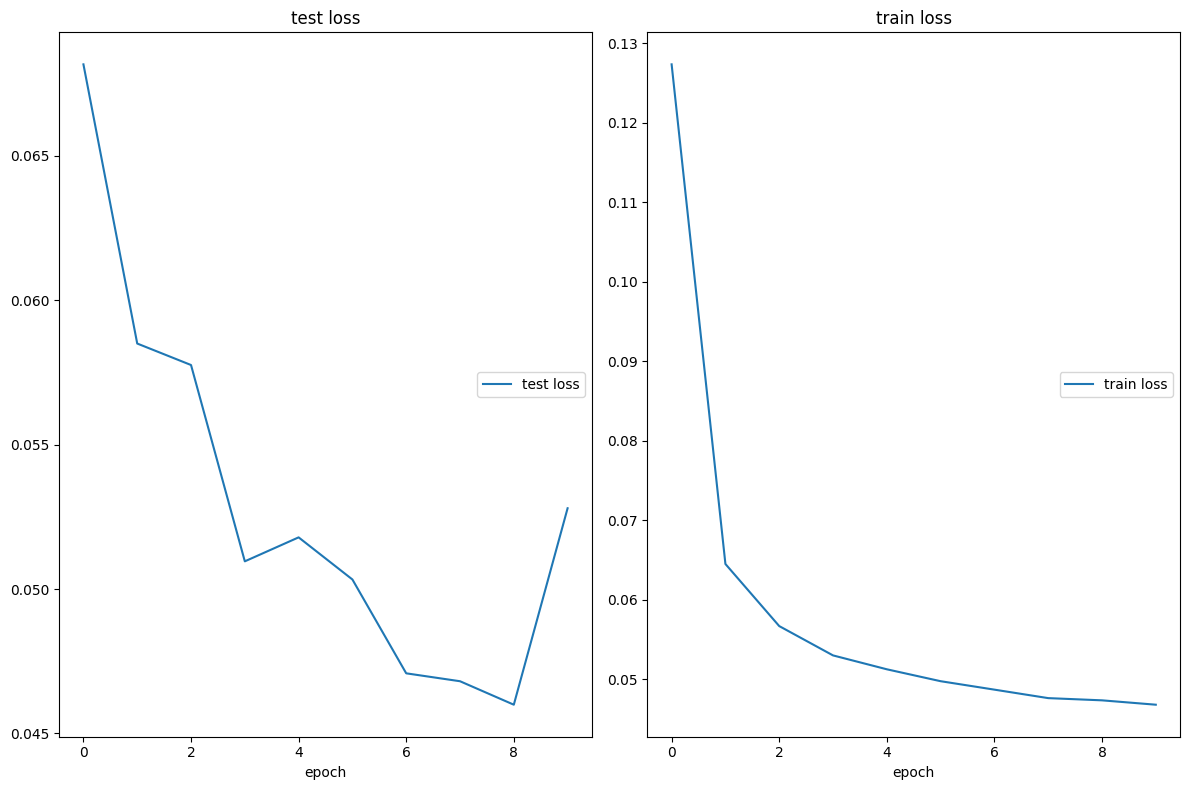

test loss
	test loss        	 (min:    0.046, max:    0.068, cur:    0.053)
train loss
	train loss       	 (min:    0.047, max:    0.127, cur:    0.047)


In [13]:
for epoch in range(10):
    logs = {}
    model.train()
    train_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs = inputs.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        targets = targets.to(device)
        targets = targets.permute(0, 2, 1, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}")
    logs['train loss'] = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            inputs = inputs.permute(0, 2, 1, 3, 4)
            targets = targets.to(device)
            targets = targets.permute(0, 2, 1, 3, 4)
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            val_loss += test_loss.item()

    print(f"Epoch {epoch+1}: Validation Loss: {val_loss / len(test_loader):.4f}")
    logs['test loss'] = val_loss / len(test_loader)

    liveloss.update(logs)
    liveloss.draw()

    scheduler.step(val_loss / len(test_loader))

The final losses indicate that the model has successfully minimised both training and test loss, with the train loss (min: 0.047, cur: 0.047) aligning closely with the test loss (min: 0.046, cur: 0.053). And the graphs suggest the model keeps learning effectively over time and is not stuck in a poor local minimum.

The fluctuations in the test loss indicate that there might be some overfitting or variability in how well the model generalises to unseen data. However, the test loss is very small (ranging from 0.046-0.068), fluctuations might become more noticeable relative to the overall scale of the loss.

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/Project/task1a_unet.pth')
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/task1a_unet.pth', weights_only=True))

### Visualisation
In this section, we evaluate the performance of our model on a specific event window by predicting and comparing the VIL values. We will use a selected event and frame window to extract the input, predicted, and ground truth frames.

Our goal is to analyse the model's prediction quality by visualising the predicted frames and comparing them with the target values. This will allow us to assess how well the model generalises to unseen data and identify areas where it may be underperforming.

In [18]:
def predict_specific_window(event_id, start_frame=0):
    dataset = StormDataset([event_id])

    sample_index = None
    for idx, (eid, start) in enumerate(test_dataset.samples):
        if start == start_frame:
            sample_index = idx
            break

    if sample_index is None:
        raise ValueError(f"Frame window {start_frame}-{start_frame+12} does not exist for event {event_id}")

    inputs, targets = dataset[sample_index]

    model.eval()
    with torch.no_grad():
        inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)

    input_frames = inputs.squeeze().cpu().numpy() * 255
    predicted_vil = outputs.squeeze().cpu().numpy() * 255
    true_vil = targets.squeeze().cpu().numpy() * 255

    input_frames = input_frames.astype(np.uint8)
    predicted_vil = np.clip(predicted_vil, 0, 255).astype(np.uint8)
    true_vil = true_vil.astype(np.uint8)

    return input_frames, predicted_vil, true_vil

start_frame = 0
input, vil_prediction, ground_truth = predict_specific_window("S842315", start_frame)

In [27]:
def make_gif(outfile, files, fps=10, loop=0):
    "Helper function for saving GIFs"
    imgs = [PIL.Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='gif', append_images=imgs[1:],
                 save_all=True, duration=int(1000/fps), loop=loop)
    im = IPython.display.Image(filename=outfile)
    im.reload()
    return im

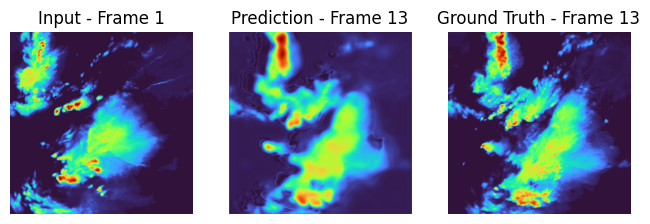

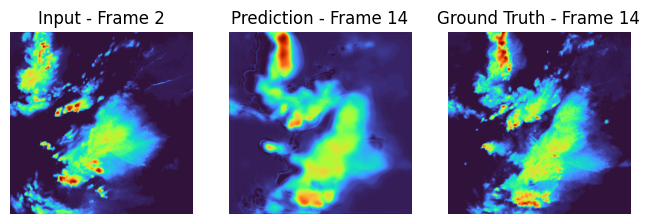

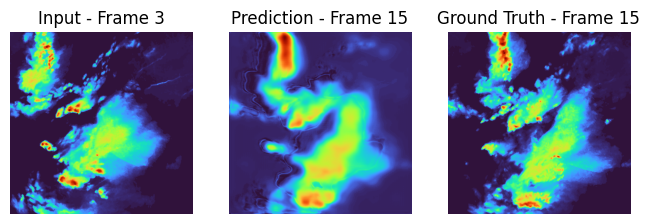

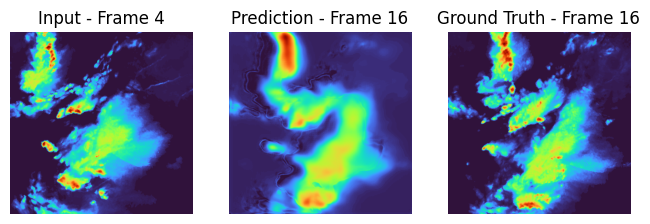

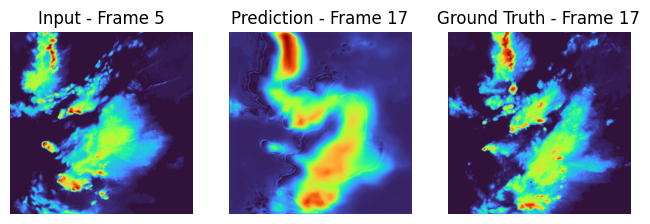

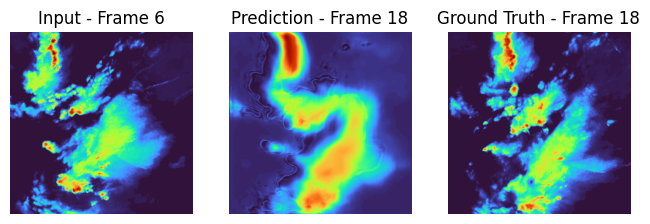

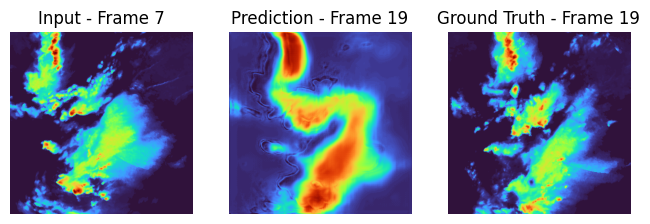

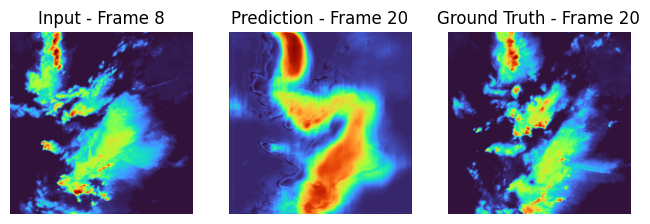

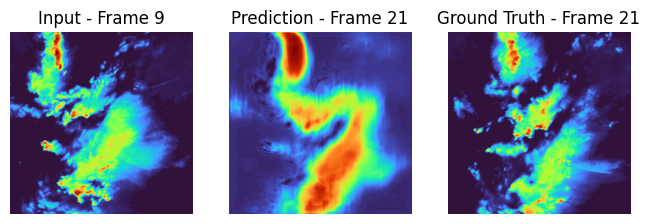

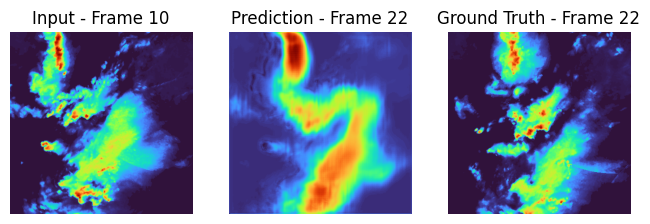

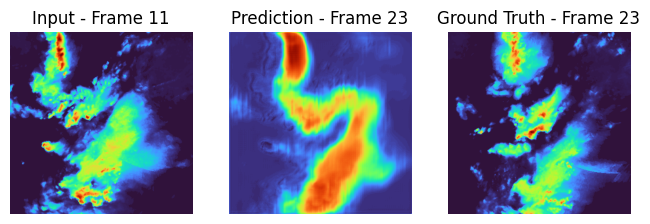

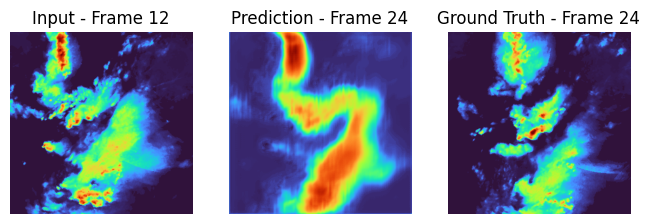

In [28]:
def plot_vil_prediction_vs_ground_truth(start, input_vil, vil_prediction, ground_truth):
    num_frames = vil_prediction.shape[0]

    for frame_idx in range(num_frames):
        fig, axes = plt.subplots(1, 3, figsize=(8, 4))

        axes[0].imshow(input_vil[frame_idx], cmap="turbo")
        axes[0].set_title(f"Input - Frame {start + frame_idx + 1}")
        axes[0].axis("off")

        axes[1].imshow(vil_prediction[frame_idx], cmap="turbo")
        axes[1].set_title(f"Prediction - Frame {start + frame_idx + 13}")
        axes[1].axis("off")

        axes[2].imshow(ground_truth[frame_idx], cmap="turbo")
        axes[2].set_title(f"Ground Truth - Frame {start + frame_idx + 13}")
        axes[2].axis("off")

        plt.show()

plot_vil_prediction_vs_ground_truth(start_frame, input, vil_prediction, ground_truth)

The model's predictions are quite accurate in the initial frames, but as the sequence progresses, the error gradually increases. This is a common behaviour in sequence forecasting models due to the fact that the small errors in earlier frames can compound over time. This leads to a divergence from the ground truth, making later predictions less accurate.

Also, meteorological events are inherently chaotic, meaning that even small variations in input can lead to significant differences in future states. As the model predicts further into the sequence, it faces more uncertainty, making precise forecasting more challenging.

In [29]:
def plot_difference(start, vil_prediction, ground_truth, frame_idx=0, output_gif=False, gif_name="difference.gif"):
    """
    Plot and optionally save the difference between ground truth and predictions.

    Args:
        vil_prediction (numpy array): Predicted VIL frames, shape (T, H, W).
        ground_truth (numpy array): Ground truth VIL frames, shape (T, H, W).
        frame_idx (int): Frame index to plot for difference.
        output_gif (bool): Whether to output the difference as a GIF.
        gif_name (str): Name of the GIF file.
    """
    # Compute the absolute difference
    difference = np.abs(vil_prediction - ground_truth)

    # Normalize difference for better visualization
    max_diff = np.max(difference)
    difference_normalized = (difference / max_diff) * 255 if max_diff > 0 else difference

    def plot_frame(frame_idx):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # Predicted VIL
        axes[0].imshow(vil_prediction[frame_idx], cmap="turbo")
        axes[0].set_title(f"Prediction - Frame {start+frame_idx+12}")
        axes[0].axis("off")

        # Ground Truth VIL
        axes[1].imshow(ground_truth[frame_idx], cmap="turbo")
        axes[1].set_title(f"Ground Truth - Frame {start+frame_idx+12}")
        axes[1].axis("off")

        if output_gif:
            file = f"_temp_diff_frame_{start+frame_idx+12}.png"
            fig.savefig(file, bbox_inches="tight", dpi=150, pad_inches=0.02, facecolor="white")
            plt.close()
        else:
            plt.show()

    if output_gif:
        temp_files = []
        for frame_idx in range(difference.shape[0]):
            file = f"_temp_diff_frame_{start+frame_idx+12}.png"
            temp_files.append(file)
            plot_frame(frame_idx)
        im = make_gif(gif_name, temp_files, fps=10)
        for file in temp_files:
            os.remove(file)
        print(f"GIF saved as {gif_name}")
    else:
        plot_frame(frame_idx)

GIF saved as vil_difference.gif


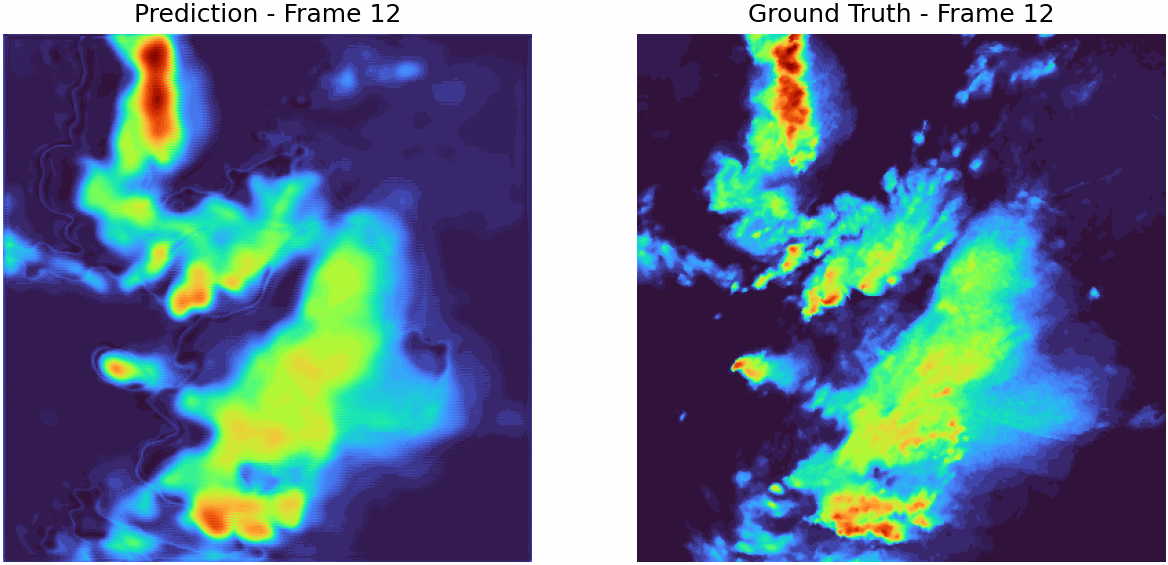

In [30]:
# Visualize the difference
plot_difference(start_frame, vil_prediction, ground_truth, output_gif=True, gif_name="vil_difference.gif")

from IPython.display import Image, display

# Display the GIF
gif_path = "vil_difference.gif"
display(Image(filename=gif_path))

Despite the increasing error over time, the general structure of the predictions remains accurate. The model successfully captures the overall shape and movement of the storm, suggesting that it has learned important spatial and temporal patterns while training. This comparison indicates that the model struggles more with finer details rather than overall trends, which is expected in this type of forecasting task.

Future improvements could involve adding more skip connections, incorporating self-attention or transformer-based architectures to help the model learn long-range dependencies more effectively.

### Scaling Laws 
**How does the performance of model change with compute, data size and model size?**

#### Dataset Size

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_ids = pd.read_csv("data/events.csv")['id'].unique()
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)
criterion = nn.L1Loss()

percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
dat_losses = []

for pct in percentages:
    num_samples = int(len(train_ids) * pct)
    selected_ids = train_ids[:num_samples]

    train_dataset = StormDataset(selected_ids)
    val_dataset = StormDataset(val_ids)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

    model = UNet3D(in_channels=1, out_channels=1, in_filters=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(5):
        print(f"\n🔹 Dataset {int(pct*100)}% - Epoch {epoch+1}/5")
        train_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # (B, 12, 1, H, W)
            inputs = inputs.permute(0, 2, 1, 3, 4)
            targets = targets.to(device)
            targets = targets.permute(0, 2, 1, 3, 4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model_path = f"/content/gdrive/MyDrive/Project/datasize/unet_{int(pct*100)}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model {int(pct*100)}% saved to {model_path}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Evaluating {int(pct*100)}%", leave=True):
            inputs = inputs.to(device)  # (B, 12, 1, H, W)
            inputs = inputs.permute(0, 2, 1, 3, 4)
            targets = targets.to(device)
            targets = targets.permute(0, 2, 1, 3, 4)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    dat_losses.append(avg_loss)


🔹 Dataset 20% - Epoch 1/5

🔹 Dataset 20% - Epoch 2/5

🔹 Dataset 20% - Epoch 3/5

🔹 Dataset 20% - Epoch 4/5

🔹 Dataset 20% - Epoch 5/5
Model 20% saved to /content/gdrive/MyDrive/Project/datasize/unet_20.pth


Evaluating 20%: 100%|██████████| 480/480 [00:15<00:00, 31.70it/s]


Validation Loss: 0.0650

🔹 Dataset 40% - Epoch 1/5

🔹 Dataset 40% - Epoch 2/5

🔹 Dataset 40% - Epoch 3/5

🔹 Dataset 40% - Epoch 4/5

🔹 Dataset 40% - Epoch 5/5
Model 40% saved to /content/gdrive/MyDrive/Project/datasize/unet_40.pth


Evaluating 40%: 100%|██████████| 480/480 [00:15<00:00, 31.60it/s]


Validation Loss: 0.0542

🔹 Dataset 60% - Epoch 1/5

🔹 Dataset 60% - Epoch 2/5

🔹 Dataset 60% - Epoch 3/5

🔹 Dataset 60% - Epoch 4/5

🔹 Dataset 60% - Epoch 5/5
Model 60% saved to /content/gdrive/MyDrive/Project/datasize/unet_60.pth


Evaluating 60%: 100%|██████████| 480/480 [00:15<00:00, 31.73it/s]


Validation Loss: 0.0494

🔹 Dataset 80% - Epoch 1/5

🔹 Dataset 80% - Epoch 2/5

🔹 Dataset 80% - Epoch 3/5

🔹 Dataset 80% - Epoch 4/5

🔹 Dataset 80% - Epoch 5/5
Model 80% saved to /content/gdrive/MyDrive/Project/datasize/unet_80.pth


Evaluating 80%: 100%|██████████| 480/480 [00:15<00:00, 31.30it/s]


Validation Loss: 0.0492

🔹 Dataset 100% - Epoch 1/5

🔹 Dataset 100% - Epoch 2/5

🔹 Dataset 100% - Epoch 3/5

🔹 Dataset 100% - Epoch 4/5

🔹 Dataset 100% - Epoch 5/5
Model 100% saved to /content/gdrive/MyDrive/Project/datasize/unet_100.pth


Evaluating 100%: 100%|██████████| 480/480 [00:15<00:00, 31.52it/s]

Validation Loss: 0.0471


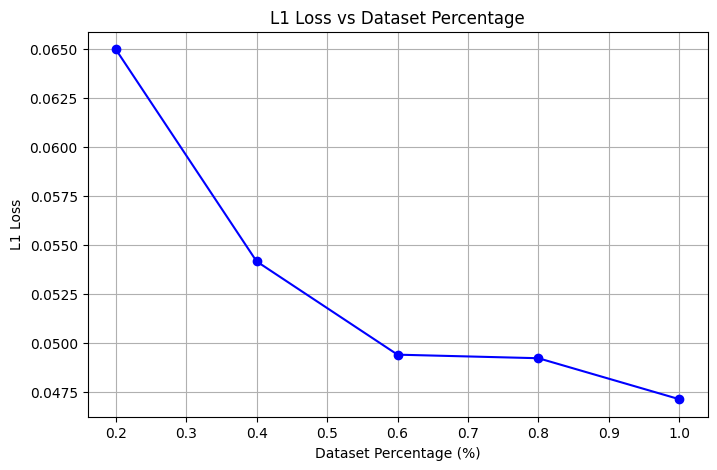

In [55]:
plt.figure(figsize=(8, 5))
plt.plot(percentages, dat_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Dataset Percentage (%)")
plt.ylabel("L1 Loss")
plt.title("L1 Loss vs Dataset Percentage")
plt.grid(True)
plt.show()

The plot illustrates how the L1 loss of validation set changes with varying dataset sizes. Overall, the L1 loss steadily decreases as the dataset percentage used to train the model increases. By increasing the dataset size from 20% to 100%, the validation L1 loss decreased by 27.54%. This indicates that a larger dataset improves the model's accuracy and reduces the L1 loss, in other words, it achieves better model performance.

#### Parameters

To alter the number of parameters, we change `in_filters` directly to affect the number of feature maps in each layer. This works because `in_filters` determines the number of convolutional filters applied in each layer, impacting feature extraction at different stages of the network.

Considering computational cost and the fact that the L1 Loss is small enough with 20% data as we investigated in Dataset Size section, we utilise only 160 events (160/800=20%) in this task.

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_ids = pd.read_csv("data/events.csv")['id'].unique()[:160]
criterion = nn.L1Loss()

train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

train_dataset = StormDataset(train_ids)
val_dataset = StormDataset(val_ids)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

model_configs = [
    {'in_filters': 1},   # param_1
    {'in_filters': 6},   # param_2
    {'in_filters': 12},  # param_3
    {'in_filters': 20},  # param_4
    {'in_filters': 32}   # param_5
]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [46]:
count = 0  # No. model
param_counts = []
val_losses = []

for config in model_configs:
    count += 1
    model = UNet3D(
        in_channels=1,
        out_channels=1,
        in_filters=config['in_filters']
    ).to(device)

    total_params = count_parameters(model)
    param_counts.append(total_params)
    print(f"\nModel: in_filters={config['in_filters']}")
    print(f"No. Parameters: {total_params:,}")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(10):
        print(f"\n🔹 Model {count} - Epoch {epoch+1}/10")
        train_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs = inputs.to(device).permute(0, 2, 1, 3, 4)
            targets = targets.to(device).permute(0, 2, 1, 3, 4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model_path = f"/content/gdrive/MyDrive/Project/parameters/unet_{count}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model with {total_params} parameters saved to {model_path}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Evaluating {total_params}", leave=True):
            inputs = inputs.to(device).permute(0, 2, 1, 3, 4)
            targets = targets.to(device).permute(0, 2, 1, 3, 4)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    val_losses.append(avg_loss)


Model: in_filters=1
No. Parameters: 6,020

🔹 Model 1 - Epoch 1/10


Epoch 1: 100%|██████████| 192/192 [00:19<00:00,  9.96it/s]



🔹 Model 1 - Epoch 2/10


Epoch 2: 100%|██████████| 192/192 [00:19<00:00,  9.96it/s]



🔹 Model 1 - Epoch 3/10


Epoch 3: 100%|██████████| 192/192 [00:19<00:00,  9.97it/s]



🔹 Model 1 - Epoch 4/10


Epoch 4: 100%|██████████| 192/192 [00:19<00:00,  9.96it/s]



🔹 Model 1 - Epoch 5/10


Epoch 5: 100%|██████████| 192/192 [00:19<00:00,  9.96it/s]



🔹 Model 1 - Epoch 6/10


Epoch 6: 100%|██████████| 192/192 [00:19<00:00,  9.95it/s]



🔹 Model 1 - Epoch 7/10


Epoch 7: 100%|██████████| 192/192 [00:19<00:00,  9.95it/s]



🔹 Model 1 - Epoch 8/10


Epoch 8: 100%|██████████| 192/192 [00:19<00:00,  9.95it/s]



🔹 Model 1 - Epoch 9/10


Epoch 9: 100%|██████████| 192/192 [00:19<00:00,  9.95it/s]



🔹 Model 1 - Epoch 10/10


Epoch 10: 100%|██████████| 192/192 [00:19<00:00,  9.96it/s]


Model with 6020 parameters saved to /content/gdrive/MyDrive/Project/parameters/unet_1.pth


Evaluating 6020: 100%|██████████| 96/96 [00:03<00:00, 30.14it/s]


Validation Loss: 0.1386

Model: in_filters=6
No. Parameters: 211,015

🔹 Model 2 - Epoch 1/10


Epoch 1: 100%|██████████| 192/192 [00:32<00:00,  5.97it/s]



🔹 Model 2 - Epoch 2/10


Epoch 2: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]



🔹 Model 2 - Epoch 3/10


Epoch 3: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]



🔹 Model 2 - Epoch 4/10


Epoch 4: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]



🔹 Model 2 - Epoch 5/10


Epoch 5: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]



🔹 Model 2 - Epoch 6/10


Epoch 6: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]



🔹 Model 2 - Epoch 7/10


Epoch 7: 100%|██████████| 192/192 [00:32<00:00,  5.97it/s]



🔹 Model 2 - Epoch 8/10


Epoch 8: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]



🔹 Model 2 - Epoch 9/10


Epoch 9: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]



🔹 Model 2 - Epoch 10/10


Epoch 10: 100%|██████████| 192/192 [00:32<00:00,  5.98it/s]


Model with 211015 parameters saved to /content/gdrive/MyDrive/Project/parameters/unet_2.pth


Evaluating 211015: 100%|██████████| 96/96 [00:03<00:00, 30.00it/s]


Validation Loss: 0.0600

Model: in_filters=12
No. Parameters: 841,789

🔹 Model 3 - Epoch 1/10


Epoch 1: 100%|██████████| 192/192 [00:42<00:00,  4.56it/s]



🔹 Model 3 - Epoch 2/10


Epoch 2: 100%|██████████| 192/192 [00:42<00:00,  4.56it/s]



🔹 Model 3 - Epoch 3/10


Epoch 3: 100%|██████████| 192/192 [00:42<00:00,  4.55it/s]



🔹 Model 3 - Epoch 4/10


Epoch 4: 100%|██████████| 192/192 [00:42<00:00,  4.56it/s]



🔹 Model 3 - Epoch 5/10


Epoch 5: 100%|██████████| 192/192 [00:42<00:00,  4.56it/s]



🔹 Model 3 - Epoch 6/10


Epoch 6: 100%|██████████| 192/192 [00:42<00:00,  4.56it/s]



🔹 Model 3 - Epoch 7/10


Epoch 7: 100%|██████████| 192/192 [00:42<00:00,  4.56it/s]



🔹 Model 3 - Epoch 8/10


Epoch 8: 100%|██████████| 192/192 [00:42<00:00,  4.55it/s]



🔹 Model 3 - Epoch 9/10


Epoch 9: 100%|██████████| 192/192 [00:42<00:00,  4.56it/s]



🔹 Model 3 - Epoch 10/10


Epoch 10: 100%|██████████| 192/192 [00:42<00:00,  4.55it/s]


Model with 841789 parameters saved to /content/gdrive/MyDrive/Project/parameters/unet_3.pth


Evaluating 841789: 100%|██████████| 96/96 [00:03<00:00, 25.77it/s]


Validation Loss: 0.0479

Model: in_filters=20
No. Parameters: 2,335,781

🔹 Model 4 - Epoch 1/10


Epoch 1: 100%|██████████| 192/192 [01:07<00:00,  2.85it/s]



🔹 Model 4 - Epoch 2/10


Epoch 2: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 3/10


Epoch 3: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 4/10


Epoch 4: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 5/10


Epoch 5: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 6/10


Epoch 6: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 7/10


Epoch 7: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 8/10


Epoch 8: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 9/10


Epoch 9: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]



🔹 Model 4 - Epoch 10/10


Epoch 10: 100%|██████████| 192/192 [01:07<00:00,  2.84it/s]


Model with 2335781 parameters saved to /content/gdrive/MyDrive/Project/parameters/unet_4.pth


Evaluating 2335781: 100%|██████████| 96/96 [00:06<00:00, 15.35it/s]


Validation Loss: 0.0513

Model: in_filters=32
No. Parameters: 5,975,969

🔹 Model 5 - Epoch 1/10


Epoch 1: 100%|██████████| 192/192 [01:31<00:00,  2.11it/s]



🔹 Model 5 - Epoch 2/10


Epoch 2: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 3/10


Epoch 3: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 4/10


Epoch 4: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 5/10


Epoch 5: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 6/10


Epoch 6: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 7/10


Epoch 7: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 8/10


Epoch 8: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 9/10


Epoch 9: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]



🔹 Model 5 - Epoch 10/10


Epoch 10: 100%|██████████| 192/192 [01:31<00:00,  2.10it/s]


Model with 5975969 parameters saved to /content/gdrive/MyDrive/Project/parameters/unet_5.pth


Evaluating 5975969: 100%|██████████| 96/96 [00:06<00:00, 14.46it/s]

Validation Loss: 0.0490


Logarithmic scaling is applied in y-axis as model parameter counts span multiple orders of magnitude (from 10<sup>3</sup> to 10<sup>6</sup>). Using a linear scale would make loss of smaller models nearly indistinguishable in plot, whereas a log scale distributes the data more evenly.

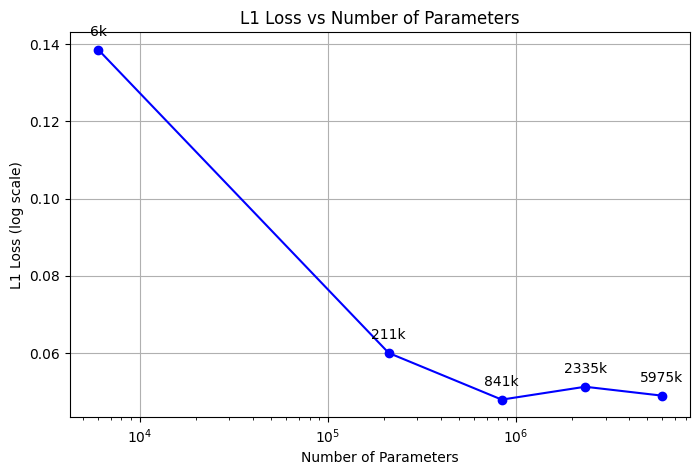

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(param_counts, val_losses, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel("Number of Parameters")
plt.ylabel("L1 Loss (log scale)")
plt.title("L1 Loss vs Number of Parameters")
plt.grid(True)
for i, (param, loss) in enumerate(zip(param_counts, val_losses)):
    plt.annotate(f"{param//1000}k", (param, loss), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

The trend indicates that increasing the number of parameters generally leads to a lower L1 loss. This is because a larger model has greater capacity to learn complex patterns in the data, allowing it to fit the training distribution more effectively. More parameters mean a higher degree of flexibility in capturing details and relationships.

However, beyond a certain point (841k parameters), the loss no longer decreases monotonically but instead exhibits slight fluctuations. This could be due to several factors. First, the model may start to overfit the training data as the it grows larger, capturing noise rather than actual patterns, leading to bad generalisation on validation sets, especially in a situation like this that we did not train on a large amount of data. Second, optimisation challenges such as vanishing gradients or increased difficulty in finding an optimal solution for complicated models may contribute to this unstable performance. Due to time and compute budget limitations, we did not explore further on the fluctions beyond this point and chose `in_filters = 6` to reach a balance between accuracy and computational cost.

#### Compute
According to https://arxiv.org/pdf/2001.08361, an estimate of the total non-embedding training compute can be calculated by C = 6NBS, where N is the model size, B is the batch number and S is the number of training steps. In this task, model size and batch size is fixed while training, so that the compute is linearly proportional to the number of training steps, AKA number of iterations. Furthermore, as we know that the loss per epoches is the average loss calculated over all the iterations in one epoch. As such, it represents the overall progress of the model across the entire dataset. Therefore, it's expected that iteration loss would have the same trend as the epoch loss with some short-term fluctuations. As a result, we can roughly consider the relationship of loss and compute as an approximation of loss-epoch trend, which is what we plotted in the training and validation section. That is, as more compute is available, the loss keeps decreasing, in orther words, the model performance improves smoothly as we increase the amount of compute.